Inspired
https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

In [1]:
from DLtools.evaluation_rec import real_eva_error,error_rec,list_eva_error
from DLtools.Data import load_data,del_less_col,check_specific_col,instant_data,intersection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, LSTM, RepeatVector,TimeDistributed,Input,Dropout, Conv1D,MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)

In [2]:
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)
    return df

In [13]:
def record_result(y_train,y_test,trainPredict,testPredict,scaler_target,save_path,syn):
    scale_Y = scaler_target.inverse_transform(y_train)
    scale_Yhat = scaler_target.inverse_transform(trainPredict.reshape(y_train.shape))
    scale_Y_t = scaler_target.inverse_transform(y_test)
    scale_Yhat_t = scaler_target.inverse_transform(testPredict.reshape(y_test.shape))

    idx=['Modelname','Feature','n_in_time','batchsize','mse','nse','r2','Test_mse','Test_nse','Test_r2']
    error = pd.DataFrame(index = idx)

    mse, nse,r2 = list_eva_error(scale_Y, scale_Yhat,n_future)
    Tmse, Tnse,Tr2 = list_eva_error(scale_Y_t, scale_Yhat_t,n_future)

    for d in range(n_future):
        index = np.arange(len(y_train)+len(y_test))
        Y= pd.Series(data=scale_Y[:,d],index=index[:len(y_train)])
        Yhat = pd.Series(data=(scale_Yhat[:,d].ravel()),index=index[:len(y_train)])
        Y_t= pd.Series(data=scale_Y_t[:,d],index=index[-len(y_test):])
        Yhat_t = pd.Series(data=(scale_Yhat_t[:,d].ravel()),index=index[-len(y_test):])
    
        plt.figure(figsize=(15,5))
        plt.plot(Y, label = "Actual")
        plt.plot(Yhat, label = "Predict")
        
        plt.plot(Y_t, label = "Actual_test")
        plt.plot(Yhat_t, label = "Predict_test")
        plt.title('[{}] Day{}\n'.format(syn,d+1)+'Water Level CPY015 Forecast vs Actuals\n'+'Train MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse[d],nse[d],r2[d])+'\nTest  MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (Tmse[d],Tnse[d],Tr2[d]))
        plt.legend()
        plt.savefig(save_path+'trial_w_mar_{}_d{}.png'.format(syn,d+1), dpi=300, bbox_inches='tight') 
        plt.show()

        col=[syn]
        _df = pd.DataFrame(["{}_{}d".format(syn,str(d+1)),n_features,n_timesteps,batch_size,mse[d], nse[d],r2[d],Tmse[d], Tnse[d],Tr2[d]],index=idx,columns=col)
        error = pd.concat([error,_df],axis=1)
        error.to_csv(save_path+'trial_evaluation_{}.csv'.format(syn))

# SETTING

In [4]:
loading = instant_data()
df_d = loading.daily_instant()

<AxesSubplot:xlabel='date'>

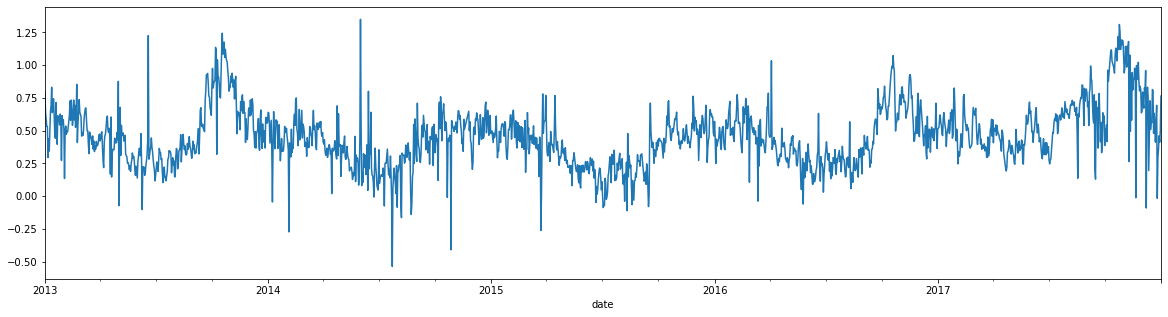

In [5]:
df = df_d["2013-01-01":"2017-12-31"]
TARGET = 'CPY015_wl'

df = df.interpolate(limit=12).apply(lambda x: x.fillna(x.mean()),axis=0)
df['Day'] = df.index.dayofyear #add day
df[TARGET].plot(figsize=(20,5))


In [41]:
# # r='data/instant_data/rain_small.csv'
# # w='data/instant_data/water_small.csv'
# # rw = load_data(r,w)
# # df =rw.df.resample('d').mean().astype('float32')
# df = df_h["2013-01-01":"2017-12-31"].interpolate(limit=360).fillna(0)

In [42]:

# # Solar-bkk del manually
# # solar=check_specific_col(df,'solar')
# # bkkwater=check_specific_col(kawa,'BKK')
# # df.drop(columns=solar+bkkwater,inplace=True)
# # df.shape

# (ADDED) MARS

In [26]:
mar = pd.read_csv('/home/song/Public/Song/Work/Thesis/featurelist_MAR_Day_ahead7d.csv')
col = [i for i in df.columns]
select_col = intersection(col,mar['feature'])

select_col.append(TARGET) # add target
df = df[select_col].astype('float32')

In [6]:
df = move_column_inplace(df,TARGET,0)
df.head()

,CPY015_wl,BKK001_rain,BKK002_rain,BKK003_rain,BKK004_rain,BKK005_rain,BKK007_rain,BKK008_rain,BKK013_rain,BKK018_rain,...,Dam_KheawNoi_Input_WaterVol,Dam_KiewKorMa_Input_WaterVol,Dam_KiewLom_Input_WaterVol,Dam_SK_Input_WaterVol,Dam_BH_Output_WaterVol,Dam_KheawNoi_Output_WaterVol,Dam_KiewKorMa_Output_WaterVol,Dam_KiewLom_Output_WaterVol,Dam_SK_Output_WaterVol,Day
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.797222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.74055,1.982156,...,1.60,0.0,0.46,3.40,23.0,4.32,0.04,1.28,23.09,1
2013-01-02,0.636250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.74055,1.982156,...,1.25,0.0,0.12,3.44,23.0,4.32,0.04,0.12,23.03,2
2013-01-03,0.581458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.74055,1.982156,...,0.90,0.0,0.56,5.50,29.0,4.32,0.04,0.12,33.15,3
2013-01-04,0.532153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.74055,1.982156,...,0.55,0.0,0.52,4.47,29.0,4.32,0.04,0.12,38.10,4
2013-01-05,0.530139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.74055,1.982156,...,0.55,0.0,0.52,4.94,29.0,4.32,0.04,0.12,38.46,5


In [7]:
save_path = '/home/song/Public/Song/Work/Thesis/output/Daily/CNN1D/'
n_past = 14
n_future = 7
n_features = len(df.columns)

# (ADDED) Feature selection

In [29]:
# def high_corr(data,threshold=.95):
#     """Eliminate first columns with high corr"""
    
#     corr_matrix = data.corr().abs()
#     # Select upper triangle of correlation matrix
#     upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#     # Find index of feature columns with correlation greater than 0.95
#     to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
#     return to_drop
# def corr_w_Y(data,target,threshold= 0.3):
#     # correlation 
#     corr_test = data.corr(method='pearson')[target]
#     corr_test = corr_test[(corr_test> threshold) | (corr_test< -threshold) ]
#     corr_test = corr_test.sort_values(ascending=False)
#     #corr_test =corr_test[1:] # eliminate Target it own
#     return corr_test

In [30]:
# data = df
# col_feature = corr_w_Y(data,TARGET,0.5).index
# data = data[col_feature]

# high_col = high_corr(data.iloc[:,1:]) #exclude target it own
# data.drop(columns=high_col,inplace=True)
# data.corr()

In [8]:
def split_series(series, n_past, n_future):
    # n_past ==> no of past observations
    # n_future ==> no of future observations 
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

######################

#####################
# SCALE
scaler_tar = MinMaxScaler()
scaler_tar.fit(df[TARGET].to_numpy().reshape(-1,1))

scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

# Train-Test split
split_pt = int(df.shape[0]*.7)
train,test = df.iloc[:split_pt,:],df.iloc[split_pt:,:]

#Split XY
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train[:,:,0]
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test[:,:,0]

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1258, 14, 294) (1258, 7)
(528, 14, 294) (528, 7)


# Customer NSE

In [9]:
import keras.backend as K

def custom_nse(y_true, y_pred):
    s, e = y_pred, y_true
    mean_observed = K.mean(e)
    # compute numerator and denominator
    numerator = K.sum((e - s) ** 2)
    denominator = K.sum((e - mean_observed)**2)
    # compute coefficient
    return 1 - (numerator / denominator)


# Encode,decode from machinery website

In [10]:
verbose, epochs, batch_size = 1, 70, 32
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

# # define model
# model = Sequential()
# model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
# model.add(RepeatVector(n_outputs))                                  # Decoder 
# model.add(LSTM(200, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(100, activation='relu')))
# model.add(TimeDistributed(Dense(1)))
# model.compile(loss='mse', optimizer='adam')
# model.summary()


reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=10, verbose=2)
callbacks = [callback_early_stopping,reduce_lr]

# ############ SIMPLE LSTM#############
# # define model
# model = Sequential()
# model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features),return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(200, activation='relu', return_sequences=False))
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(n_outputs))
# model.compile(loss='huber_loss', optimizer='adam')
# model.summary()

############ 1D CNN ######
# # define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_outputs))
model.compile(optimizer='adam', loss='mse')


history = model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=batch_size,verbose=verbose,callbacks=callbacks)

Epoch 1/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0358 - val_loss: 0.0140 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0092 - val_loss: 0.0114 - lr: 9.0000e-04
Epoch 3/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0113 - lr: 8.1000e-04
Epoch 4/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0067 - val_loss: 0.0115 - lr: 7.2900e-04
Epoch 5/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0116 - lr: 6.5610e-04
Epoch 6/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0103 - lr: 5.9049e-04
Epoch 7/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0103 - lr: 5.3144e-04
Epoch 8/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.0103 - lr: 4.7830e-04
Epoch 9/100
40/40 [==============================] - 0s 7ms/step - loss: 0.

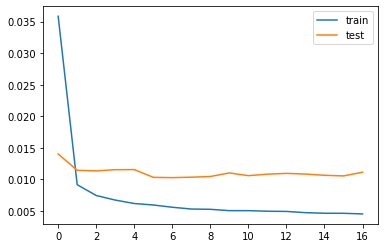

In [11]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.savefig(save_path+'loss_Daily_CNN1D.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot prediction

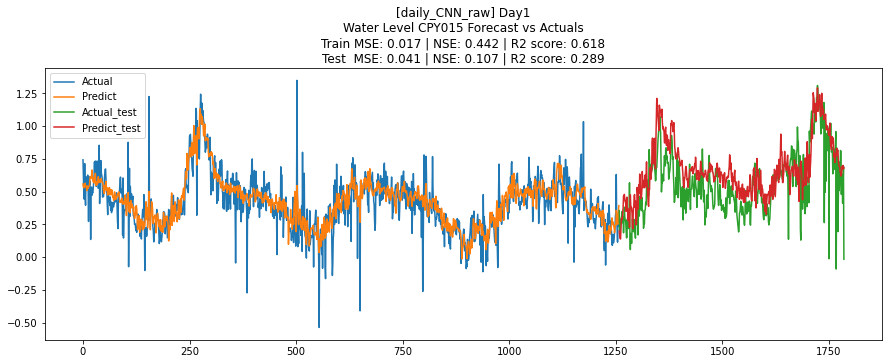

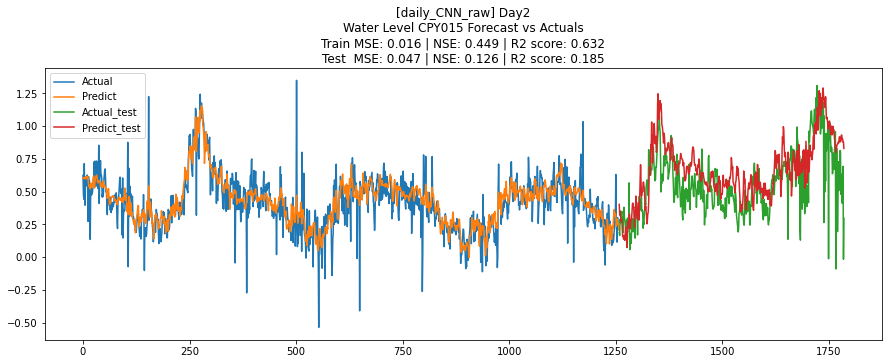

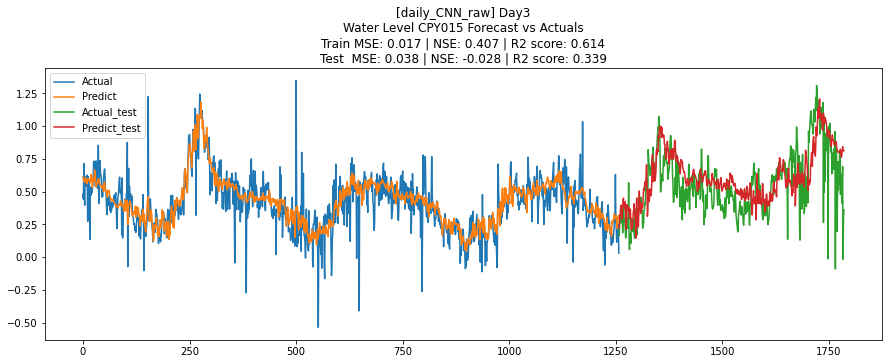

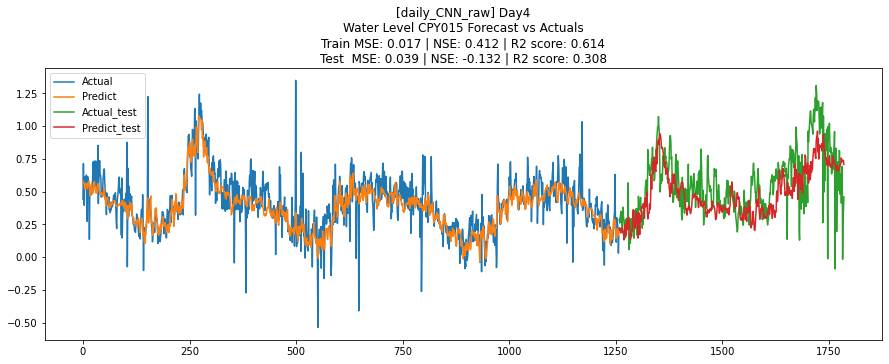

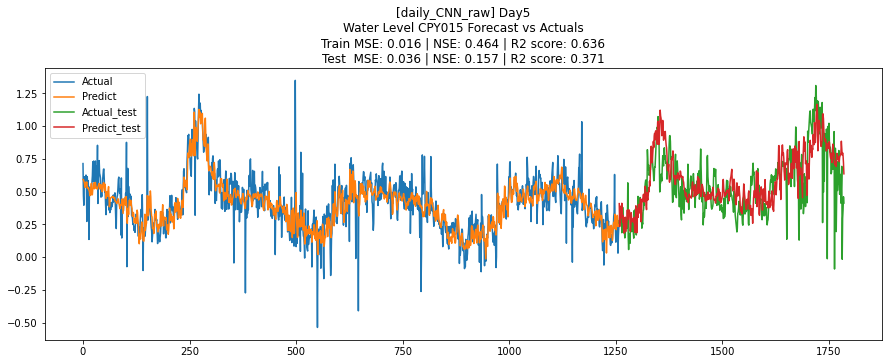

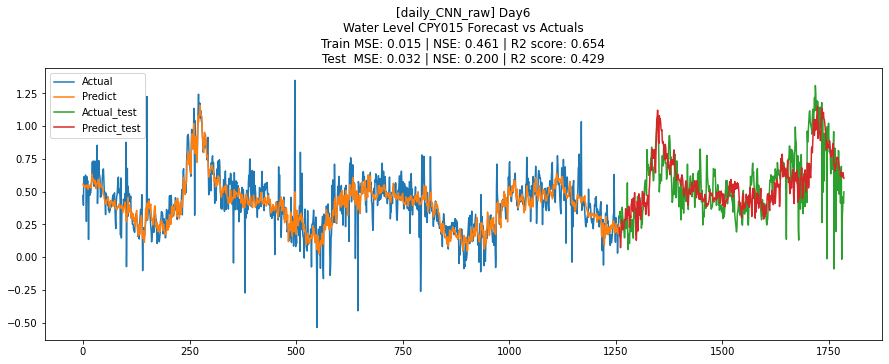

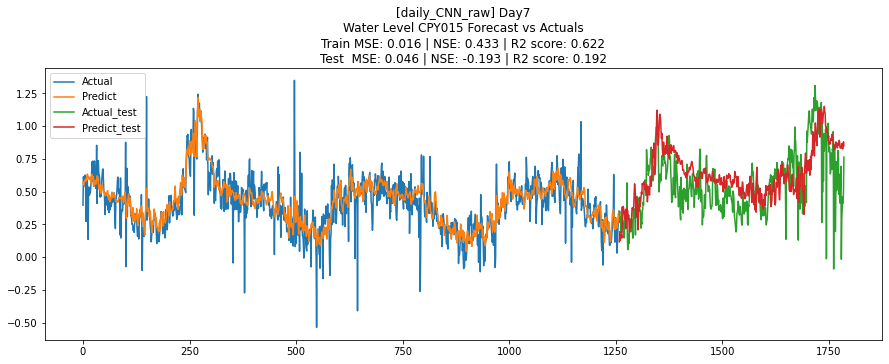

In [14]:
# get prdict result as once
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

record_result(y_train,y_test,trainPredict,testPredict,scaler_tar,save_path,'daily_CNN_raw')

# LSTM simple

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 200)               188000    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 303       
Total params: 208,403
Trainable params: 208,403
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
38/38 [==============================] - 8s 198ms/step - loss: 0.0344 - val_loss: 0.0070
Epoch 2/70
38/38 [==============================] - 4s 112ms/step - loss: 0.0066 - val_loss: 0.0111
Epoch 3/70
38/38 [==============================] - 4s 92ms/step - loss: 0.0057 - val_loss: 0.0099
Epoch 4/70
38/38 [==============================] - 3s 87ms/step - loss: 0.0058

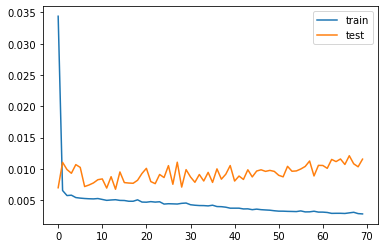

In [33]:
############ SIMPLE LSTM#############
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs))
model.compile(loss='mse', optimizer='adam')
model.summary()
# fit network
history =  model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_data=(X_test,y_test))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [34]:
# get prdict result as once
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

scale_Y = scaler_tar.inverse_transform(y_train)
scale_Yhat = scaler_tar.inverse_transform(trainPredict.reshape(y_train.shape))

scale_Y_t = scaler_tar.inverse_transform(y_test)
scale_Yhat_t = scaler_tar.inverse_transform(testPredict.reshape(y_test.shape))

mse, nse,r2 = list_eva_error(scale_Y, scale_Yhat,n_future)
Tmse, Tnse,Tr2 = list_eva_error(scale_Y_t, scale_Yhat_t,n_future)

idx=['Modelname','Feature','n_in_time','batchsize','mse','nse','r2','Test_mse','Test_nse','Test_r2']
for d in range(n_future):
    Y= pd.Series(data=scale_Y[:,d],index=index[:len(y_train)])
    Yhat = pd.Series(data=(scale_Yhat[:,d].ravel()),index=index[:len(y_train)])
    Y_t= pd.Series(data=scale_Y_t[:,d],index=index[-len(y_test):])
    Yhat_t = pd.Series(data=(scale_Yhat_t[:,d].ravel()),index=index[-len(y_test):])
    
    plt.figure(figsize=(15,5))
    plt.plot(Y, label = "Actual")
    plt.plot(Yhat, label = "Predict")
    
    plt.plot(Y_t, label = "Actual_test")
    plt.plot(Yhat_t, label = "Predict_test")
    plt.title('[Encode-Decdoe] Day{}\n'.format(d+1)+'Water Level CPY015 Forecast vs Actuals\n'+'Train MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse[d],nse[d],r2[d])+'\nTest  MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (Tmse[d],Tnse[d],Tr2[d]))
    plt.legend()
    plt.savefig(save_path+'trial_simpleLSTM_w_mar{}.png'.format(d+1), dpi=300, bbox_inches='tight')
    
    plt.show()

    col = ['LSTM']
    _df = pd.DataFrame(["LSTM_EnDec_corr_{}d".format(str(d+1)),n_features,n_timesteps,'batch_size',mse[d], nse[d],r2[d],Tmse[d], Tnse[d],Tr2[d]],index=idx,columns=col)
    error = pd.concat([error,_df],axis=1)
error.to_csv(save_path+'trial_evaluation_simpleLSTM_w_MAR.csv')


NameError: name 'index' is not defined